<a href="https://colab.research.google.com/github/Fayaz-shaik/tempo/blob/main/Emergency_and_Non_Emergency_Vehicle___Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance. Many accident victims wait for help at the site, and a delay costs them their lives. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams. 

The solution to the above problem is to create a system that automatically detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

## Dataset

Download the dataset from [here](https://drive.google.com/file/d/1NChgxuJ7RzT0YPyP19S_-F0gsmEOiG64/view?usp=sharing)


## 1. Import Libraries

In [ ]:
# for audio pre-processing and analysis:
import librosa as lib

# for audio features creation
import scipy

# for array processing:
import numpy as np

# for visualizing the data
from matplotlib import pyplot as plt
%matplotlib inline 

# for playing audio
import IPython.display as ipd

# for splitting data into train-test:
from sklearn.model_selection import train_test_split

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import * 

## 2. Load Audio Data

Using load function in librosa importing the audio files. The two audio clips contain multiple audio sounds recorded at different places.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing emergency file:
emergency, sample_rate = lib.load("/content/drive/MyDrive/audio/emergency.wav", sr=16000)

# importing non-emergency file:
non_emergency, sample_rate = lib.load('/content/drive/MyDrive/audio/non emergency.wav', sr=16000)

Remember, the audio waves are analogous and to convert the sounds into the digital i.e the binary and discrete signals, sampling process is applied. Therefore, the sample_rate (sr) of 16000 to read the above two audio clips. This sample rate means that 16000 is the average number of samples recorded per second.

### Finding the duration of the audio clips

Using the get_duration function

In [ ]:
len1 = lib.get_duration(emergency, sr=16000)
len2 = lib.get_duration(non_emergency, sr=16000)

print('The duration of the Emergency clip is {} mins and Non-Emergency clip is {} mins.'.format(round(len1/60,2), round(len2/60,2)))

The duration of the Emergency clip is 22.92 mins and Non-Emergency clip is 27.16 mins.


## 3. Data Preparation -- Preparing the Audio Sequences

In this step, preparing the audio data into audio chunks. With the sound clip of 2 seconds length and the sampling rate of 16000 for each of the audio files, will have 32,000 samples.

In [ ]:
# User-defined Function for Audio chunks audio data is the array

def audio_chunks(audio_data, num_of_samples=32000, sr=16000):
    
    # empty list to store new audio chunks formed 
    data=[]
    for i in range(0, len(audio_data), sr):
        
        # creating the audio chunk by starting with the first second & sliding the 2-second window one step at a time 
        chunk = audio_data[i: i+ num_of_samples]
        
        if(len(chunk)==32000):
            data.append(chunk)
    return data

Calling the above function audio_chunks to create seperate chunks for both Emergency and non-emergency vehicles:

In [ ]:
# Prepare Audio Chunks
emergency = audio_chunks(emergency)
non_emergency = audio_chunks(non_emergency)

In [ ]:
print('The number of chunks of Emergency is {} and Non-Emergency is {}.'.format(len(emergency), len(non_emergency)))

The number of chunks of Emergency is 1374 and Non-Emergency is 1628.


## 4. Playing the Audio Data

In [ ]:
# Emergency Sound:
ipd.Audio(emergency[45], rate=16000)

In [ ]:
# Non-Emergency Sound:
ipd.Audio(non_emergency[29], rate=16000)

## 5. Visualization of Audio Data

Visualizing the sounds waves in time domain

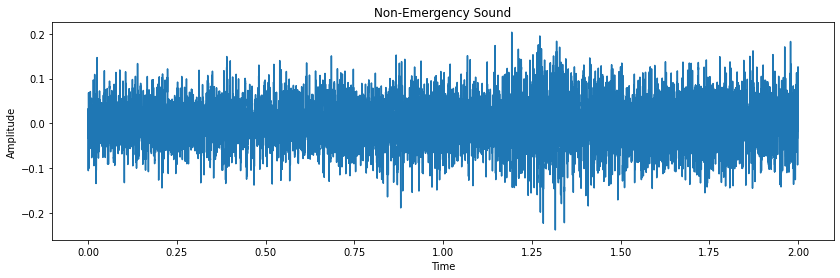

In [ ]:
# Visualization:

# Non-Emergency Sound
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[33])
plt.title('Non-Emergency Sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

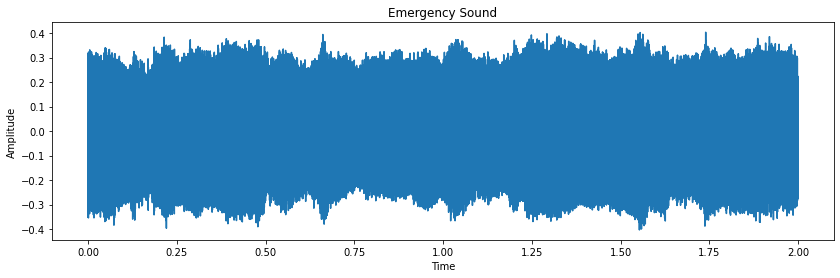

In [ ]:
# Visualization:

# Emergency Sound
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[32])
plt.title('Emergency Sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## 6. Split data into Train - Test 

Splitting the data into 80% train set and 20% testing set. 

In [ ]:
# Step 1: Combining the Emergency and Non Emergency audio chunks
audio = np.concatenate([emergency,non_emergency])

# Step 2: Assigning labels 
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate labels
labels = np.concatenate([labels1,labels2])

In [ ]:
print('The shape of the combined audio data is {}' .format(audio.shape))

The shape of the combined audio data is (3002, 32000)


In [ ]:
# Train-test splitting:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(audio), np.array(labels), stratify=labels, test_size=0.20, 
                                                    random_state=12, shuffle=True)

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('')
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (2401, 32000)
X_test (601, 32000)

Y_train (2401,)
Y_test (601,)


In [ ]:
# Reshaping the 2-Dimensional array into 3-Dimensional array by setting the third dimension to 1:

X_train_features = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test), -1,1)

print('The reshaped X_train array has size:', X_train_features.shape)
print('The reshaped X_test array has size:', X_test_features.shape)

The reshaped X_train array has size: (2401, 32000, 1)
The reshaped X_test array has size: (601, 32000, 1)


## Audio Classification Using Time Domain Features

## Model Architecture using LSTM Model

Let's define the model architecture using LSTM layers and the time domain features.

In [ ]:
# Reshaping the Audio chunks:

X_train_features = X_train.reshape(len(X_train),-1,160)
X_test_features = X_test.reshape(len(X_test), -1,160)

print('The reshaped X_train array has size:', X_train_features.shape)
print('The reshaped X_test array has size:', X_test_features.shape)

The reshaped X_train array has size: (2401, 200, 160)
The reshaped X_test array has size: (601, 200, 160)


In [ ]:
# LSTM based deep learning model architecture
def lstm_model(X_tr):
    
    inputs = Input(shape=(X_tr.shape[1], X_tr.shape[2]))
    
    # LSTM Layer 1
    x = LSTM(128)(inputs)
    x = Dropout(0.3)(x)
    
    # LSTM Layer 2
    x = LSTM(128)(inputs)
    x = Dropout(0.3)(x)
    
    # LSTM Layer 3
    x = LSTM(64)(inputs)
    x = Dropout(0.3)(x)
    
    # Dense Layer
    x = Dense(64, activation = 'relu')(x)
    x = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs, x)
    
    # Model compiler
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    # Model Checkpoint
    mc = ModelCheckpoint('best_model_lstm.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    return model, mc

In [ ]:
# Calling the function
model, mc = lstm_model(X_train_features)


# Model Summary:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 160)]        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                57600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 61,825
Trainable params: 61,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model:

history=model.fit(X_train_features, Y_train, epochs=40, 
                  callbacks=[mc], batch_size=32,              # batch size + epochs : hyperparameters
                  validation_data=(X_test_features, Y_test))

Epoch 1/40
76/76 [==============================] - 7s 52ms/step - loss: 0.6661 - acc: 0.5927 - val_loss: 0.6512 - val_acc: 0.7105

Epoch 00001: val_loss improved from inf to 0.65116, saving model to best_model_lstm.hdf5
Epoch 2/40
76/76 [==============================] - 3s 44ms/step - loss: 0.5508 - acc: 0.7693 - val_loss: 0.4783 - val_acc: 0.7770

Epoch 00002: val_loss improved from 0.65116 to 0.47825, saving model to best_model_lstm.hdf5
Epoch 3/40
76/76 [==============================] - 3s 44ms/step - loss: 0.5149 - acc: 0.7347 - val_loss: 0.4839 - val_acc: 0.8519

Epoch 00003: val_loss did not improve from 0.47825
Epoch 4/40
76/76 [==============================] - 3s 44ms/step - loss: 0.3843 - acc: 0.8755 - val_loss: 0.4064 - val_acc: 0.8819

Epoch 00004: val_loss improved from 0.47825 to 0.40637, saving model to best_model_lstm.hdf5
Epoch 5/40
76/76 [==============================] - 3s 44ms/step - loss: 0.3313 - acc: 0.8834 - val_loss: 0.3330 - val_acc: 0.8785

Epoch 00005: v

In [ ]:
# load best model weights
model.load_weights('best_model_lstm.hdf5')

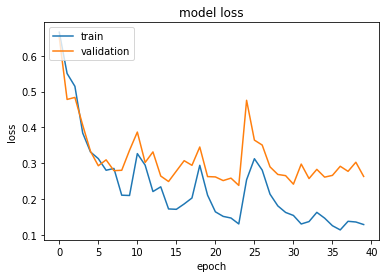

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# Model Evaluation:

_,acc = model.evaluate(X_test_features, Y_test)
print("Accuracy:",acc)

19/19 [==============================] - 0s 16ms/step - loss: 0.2379 - acc: 0.9251
Accuracy: 0.9251247644424438


## Prediction

In [39]:
# For Prediction using LSTM: the input audio

index = 513
test_audio = X_test[index]

# Using IPython.display to play the audio
ipd.Audio(test_audio, rate=16000)

In [40]:
# classification

feature = X_test_features[index]

prob = model.predict(feature.reshape(1,-1,160))

if (prob[0][0] < 0.5):
    pred='emergency'
else:
    pred='non emergency' 

print("Prediction:",pred)

Prediction: non emergency


--------------------

## Spectrogram Features

Defining a function that computes the spectrogram for a given audio chunk

In [43]:
def spec_log(audio, sample_rate, eps = 1e-10):
    
    freq, times, spec = scipy.signal.spectrogram(audio, fs= sample_rate, nperseg=320, noverlap=160)
    return freq, times, np.log(spec.T.astype(np.float32) + eps)

Defining a function for showing the spectrogram:

In [44]:
# For Visualization of the Spectrogram:

def spec_plot(spectrogram, label):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(211)
    ax.imshow(spectrogram.T, aspect='auto', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of '+label)
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Freqs in Hz')
    plt.show()

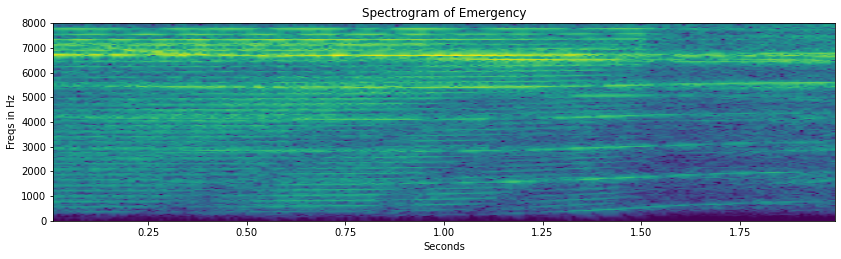

In [45]:
# Computing and Visualizing the Spectrogram for Emergency:

freqs, times, spectrogram = spec_log(emergency[162], sample_rate)
spec_plot(spectrogram,"Emergency")

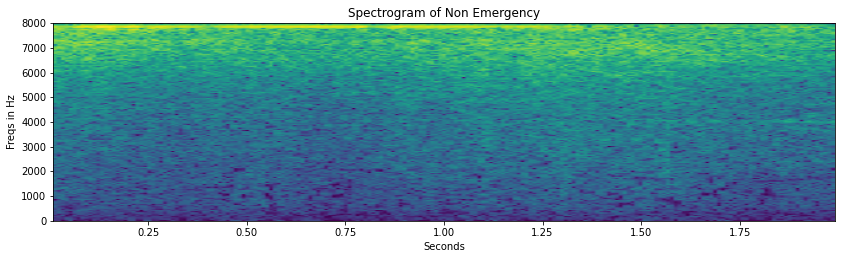

In [46]:
# Computing and Visualizing the Spectrogram for Non-Emergency:
freqs, times, spectrogram = spec_log(non_emergency[162], sample_rate)
spec_plot(spectrogram,"Non Emergency")

In non-emergency vehicle's spectrogram, no horizontal lines are depicted. This could be due to the absence of siren sound.

In [47]:
spectrogram.shape

(199, 161)

## Extract the spectrogram features

Extract the spectrogram features from the same audio set that we used above during the time domain features.

In [48]:
def extract_spec_features(X_tr):
    
    # defining empty list to store the features:
    features = []
    
    # We only need the 3rd array of Spectrogram so assigning the first two arrays as _
    for i in X_tr:
        _,_, spectrogram = spec_log(i, sample_rate)

        mean = np.mean(spectrogram, axis=0)
        std = np.std(spectrogram, axis=0)
        spectrogram = (spectrogram - mean)/std

        features.append(spectrogram)
    
    # returning the features as array
    return np.array(features)

In [49]:
# Calling extract function to get training and testing sets:

X_train_features = extract_spec_features(X_train)
X_test_features = extract_spec_features(X_test)

## Calling the LSTM Model

In [50]:
model_2, mc_2 = lstm_model(X_train_features)

In [51]:
# Number of parameters and shape of each layer:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 199, 161)]        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                57856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 62,081
Trainable params: 62,081
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Train the model
history=model_2.fit(X_train_features, Y_train, epochs=40, callbacks=[mc_2], batch_size=32, 
                    validation_data=(X_test_features, Y_test))

Epoch 1/40
76/76 [==============================] - 3s 45ms/step - loss: 0.0624 - acc: 0.9800 - val_loss: 0.1937 - val_acc: 0.9301

Epoch 00001: val_loss improved from 0.23349 to 0.19373, saving model to best_model_lstm.hdf5
Epoch 2/40
76/76 [==============================] - 3s 44ms/step - loss: 0.0270 - acc: 0.9954 - val_loss: 0.2237 - val_acc: 0.9268

Epoch 00002: val_loss did not improve from 0.19373
Epoch 3/40
76/76 [==============================] - 3s 45ms/step - loss: 0.0665 - acc: 0.9783 - val_loss: 0.2317 - val_acc: 0.9218

Epoch 00003: val_loss did not improve from 0.19373
Epoch 4/40
76/76 [==============================] - 3s 44ms/step - loss: 0.0183 - acc: 0.9954 - val_loss: 0.2733 - val_acc: 0.9135

Epoch 00004: val_loss did not improve from 0.19373
Epoch 5/40
76/76 [==============================] - 3s 44ms/step - loss: 0.0127 - acc: 0.9975 - val_loss: 0.2303 - val_acc: 0.9368

Epoch 00005: val_loss did not improve from 0.19373
Epoch 6/40
76/76 [=========================

Load the weights of the best model:

In [57]:
model_2.load_weights('best_model_lstm.hdf5')

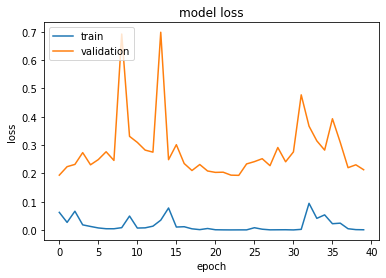

In [58]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation

Evaluating the performance of the model on the test set:

In [59]:
_,acc = model_2.evaluate(X_test_features, Y_test)
print("Accuracy:",acc)

19/19 [==============================] - 0s 17ms/step - loss: 0.1930 - acc: 0.9601
Accuracy: 0.960066556930542


In [ ]:
-----------------